In [1]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.optimize import curve_fit
import pandas as pd
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


/grid_mnt/data__DATA/data.polcalice/data/flc/shi/miniconda3/envs/my_notebook_env/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/grid_mnt/data__DATA/data.polcalice/data/flc/shi/miniconda3/envs/my_notebook_env/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/grid_mnt/data__DATA/data.polcalice/data/flc/shi/miniconda3/envs/my_notebook_env/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/grid_mnt/data__DATA/data.polcalice/data/flc/shi/miniconda3/envs/my_notebook_env/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               

Welcome to JupyROOT 6.28/04


Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/10.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/20.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/30.0GeV.root
Processing file: /home/llr/ilc/shi/dat

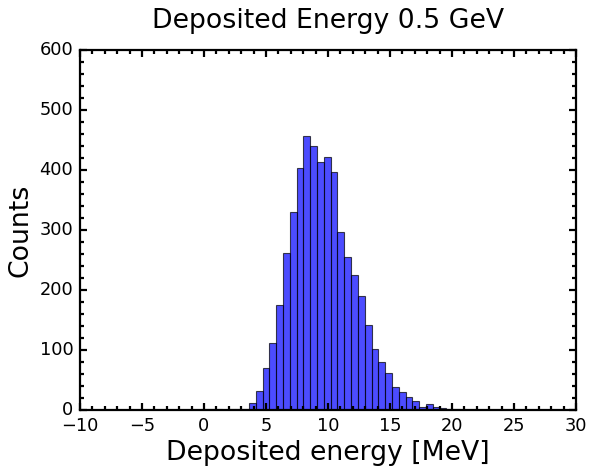

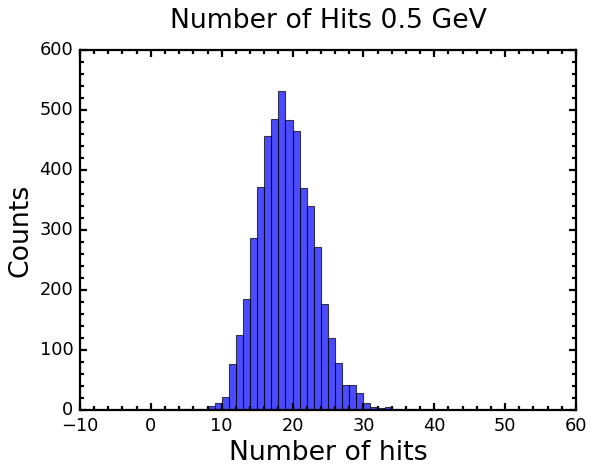

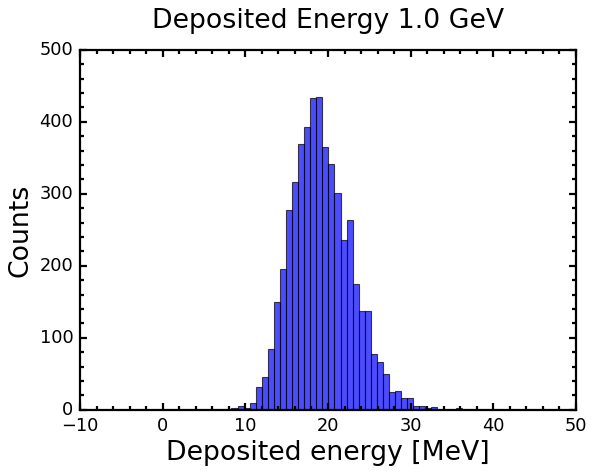

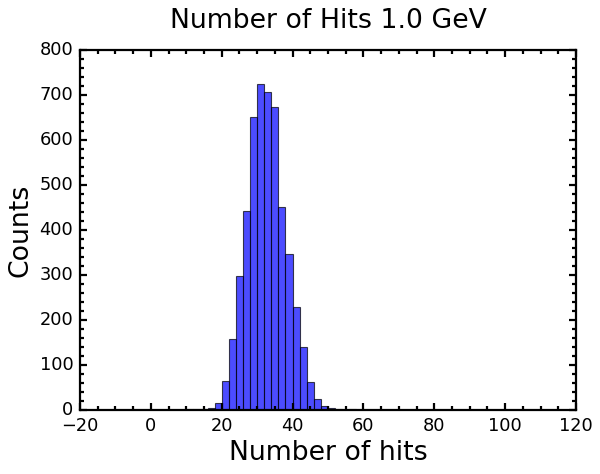

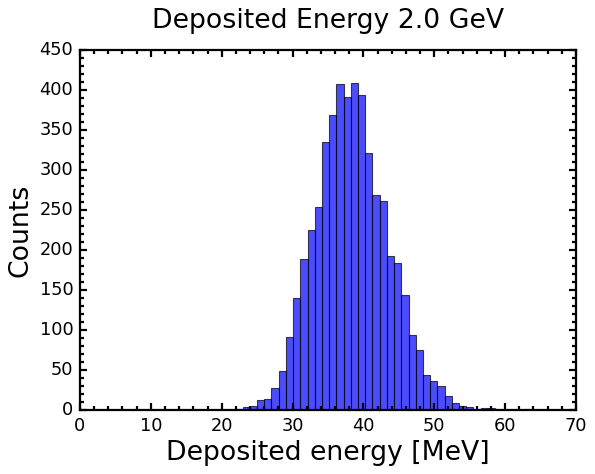

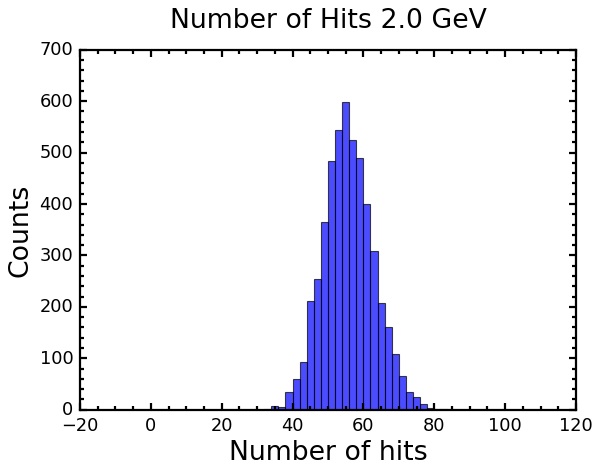

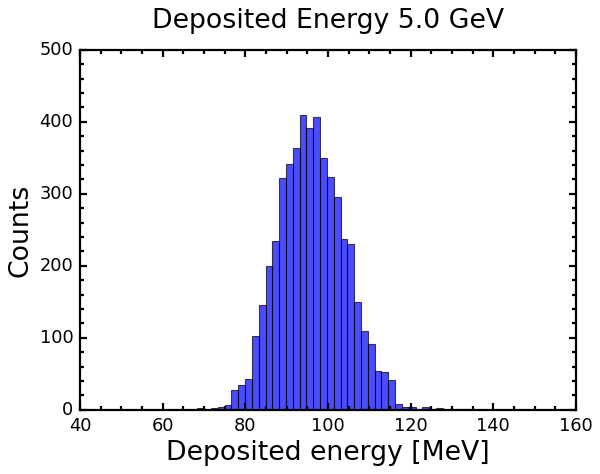

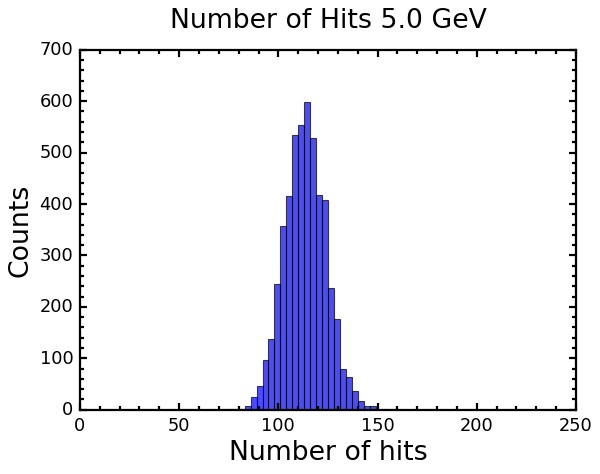

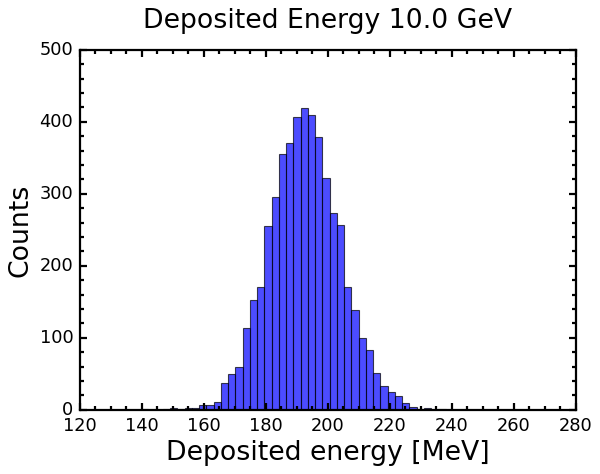

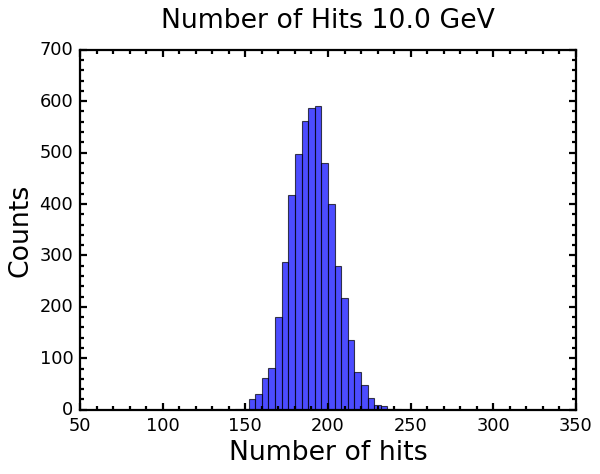

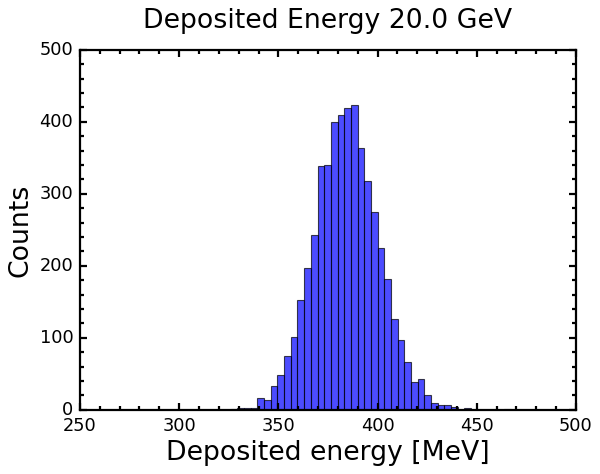

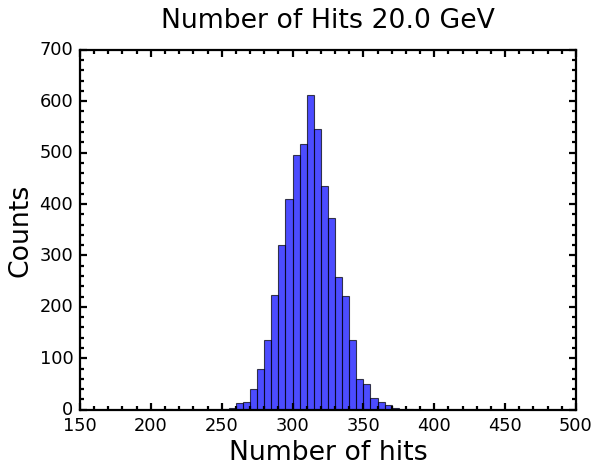

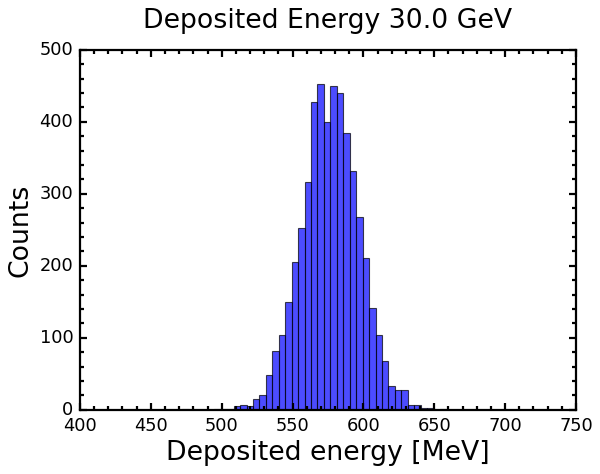

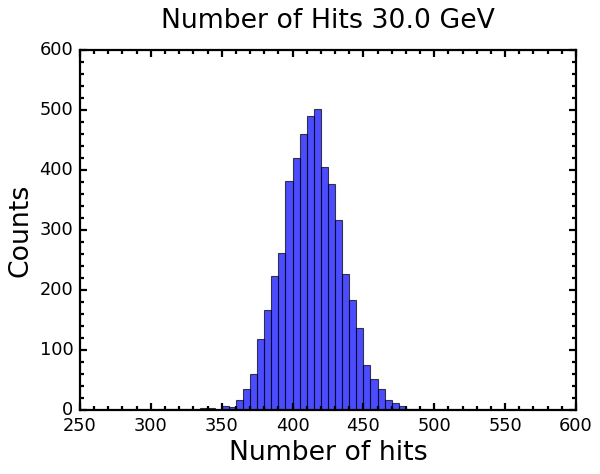

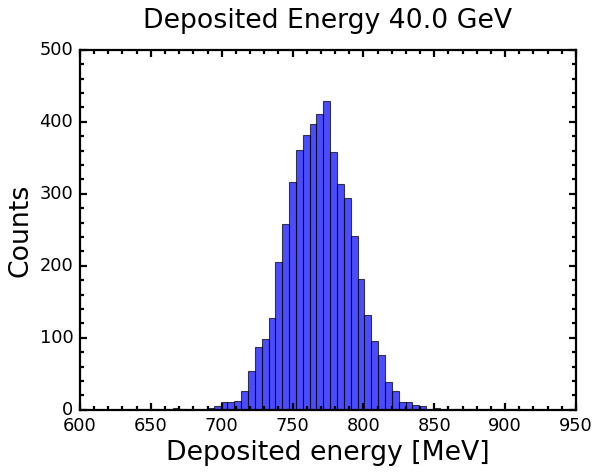

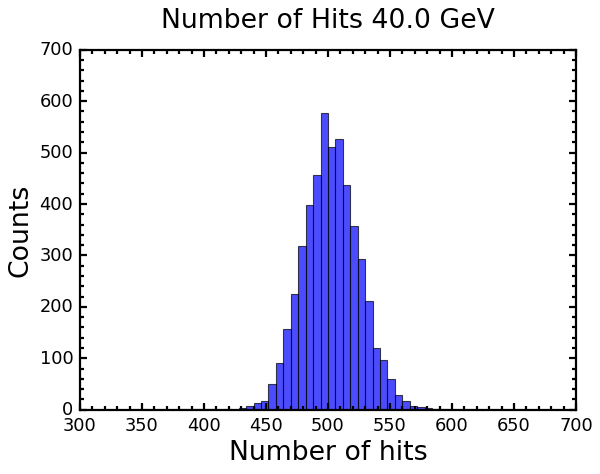

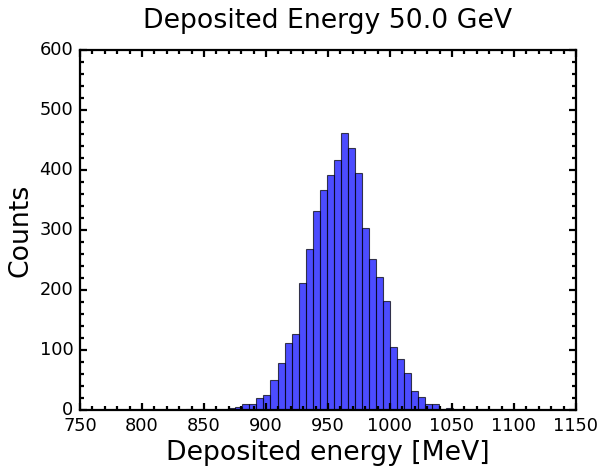

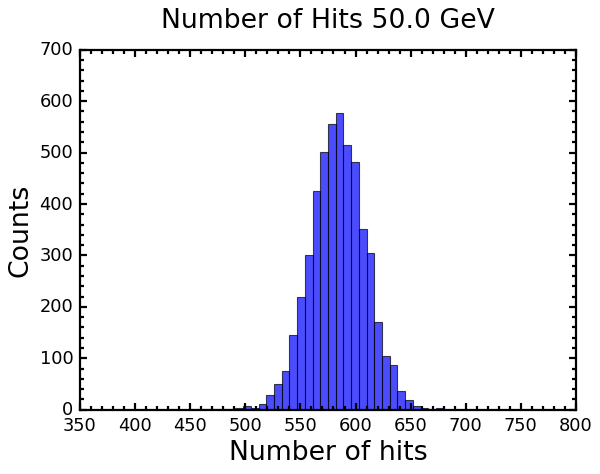

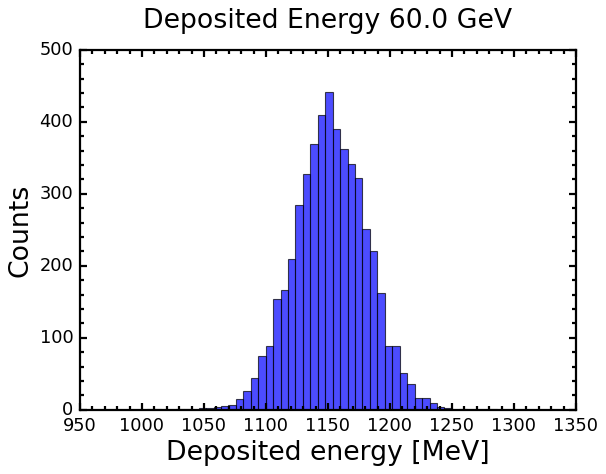

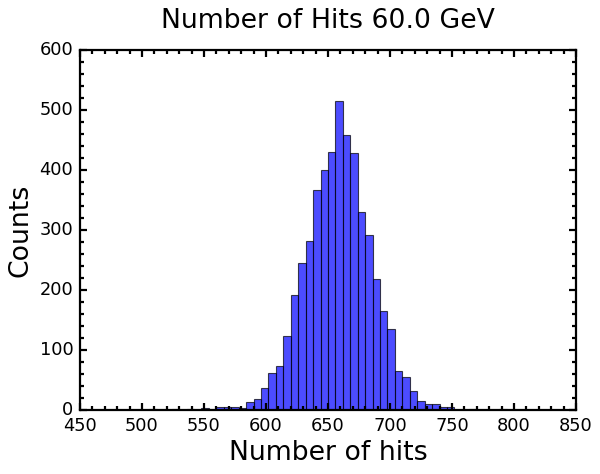

In [ ]:
# 打开 ROOT 文件，载入 events tree
DataPath="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
ParticleEnergy=(0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
Fig_E = []
Fig_N = []
for i_E in range(len(ParticleEnergy)):
    input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    Event_energy = [np.sum(e) * 1000 for e in energy]
    Numer_hits = [len(e) for e in energy]

    #Sum of E
    Nbins=30
    counts, bin_edges = np.histogram(Event_energy, bins=Nbins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    peak_x = bin_centers[np.argmax(counts)]
    rms = np.sqrt(np.mean((Event_energy - peak_x)**2))
    fig,ax = plt.subplots(figsize=fig_size)
    ax.hist(Event_energy, bins=50, range=(peak_x - 5*rms, peak_x + 5*rms), color='blue', alpha=0.7)
    ax.set_xlabel("Deposited energy [MeV]")
    ax.set_ylabel("Counts")
    ax.set_title("Deposited Energy {:.1f} GeV".format(ParticleEnergy[i_E]))
    ax.grid(False)
    Fig_E.append(fig)
    #Number of hits
    counts, bin_edges = np.histogram(Numer_hits, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    peak_x = bin_centers[np.argmax(counts)]
    rms = np.sqrt(np.mean((Numer_hits - peak_x)**2))
    #Initialize range parameters
    fig,ax = plt.subplots(figsize=fig_size)
    ax.hist(Numer_hits, bins=50, range=( int((peak_x - 5*rms)/50)*50, int((peak_x + 5*rms)/50+1)*50 ), color='blue', alpha=0.7)
    ax.set_xlabel("Number of hits")
    ax.set_ylabel("Counts")
    ax.set_title("Number of Hits {:.1f} GeV".format(ParticleEnergy[i_E]))
    ax.grid(False)
    Fig_N.append(fig)


In [3]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(i_E, type):
    if type == "E":
        fig = Fig_E[i_E]
    elif type == "N":
        fig = Fig_N[i_E]
    else:
        raise ValueError("Type must be 'E' for energy or 'N' for number of hits.")
    ax = fig.axes[0] 
    patches = ax.patches
    counts = np.array([p.get_height() for p in patches])
    bin_edges = np.array([p.get_x() for p in patches] + [patches[-1].get_x() + patches[-1].get_width()])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean = np.average(bin_centers, weights=counts)
    peak = bin_centers[np.argmax(counts)]
    rms = np.sqrt(np.mean((bin_centers - peak)**2))

    #Gamma Fit
    theta = abs(mean - peak)
    k = rms / np.sqrt(theta)
    mu = abs(mean - k*theta)
    params_gamma_initial = [sum(counts), k, mu, theta]
    lower_bounds = np.array(params_gamma_initial) * 0.5
    upper_bounds = np.array(params_gamma_initial) * 100
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")

    #Gaussian Fit
    params_gauss_initial = np.array([max(counts), res_gamma, peak_gamma])
    lower_bounds = 0.5 * params_gauss_initial
    upper_bounds = 100 * params_gauss_initial
    print(f"Initial Gaussian Fit Parameters: {params_gauss_initial}")
    params_gauss, cov_gauss = curve_fit(fit_gaussian, bin_centers, counts, p0=params_gauss_initial, bounds=(lower_bounds, upper_bounds))
    peak_gauss = peak_gamma
    sigma_gauss = res_gamma * peak_gamma
    fit_mask = (bin_centers >= peak_gauss - 2 * sigma_gauss) & (bin_centers <= peak_gauss + 2 * sigma_gauss)
    x_fit = bin_centers[fit_mask]
    y_fit = counts[fit_mask]
    params_gauss, cov_gauss = curve_fit(fit_gaussian, x_fit, y_fit, p0=params_gauss_initial)
    x_fit_gauss = x_fit
    y_fit_gauss = fit_gaussian(x_fit, *params_gauss)
    peak_gauss = params_gauss[2]
    peak_gauss_error = np.sqrt(cov_gauss[2, 2])
    res_gauss = params_gauss[1]
    res_gauss_error = np.sqrt(cov_gauss[1, 1])
    print(f"Gaussian Fit Peak: {peak_gauss} ± {peak_gauss_error}, Resolution: {res_gauss} ± {res_gauss_error}")

    #Log Normal Fit
    var = rms**2
    sigma = np.sqrt(np.log(var/(mean**2)+1))
    scale = np.sqrt( var / ( np.exp(sigma**2) * (np.exp(sigma**2) - 1)) )
    loc = peak - scale*np.exp(-sigma**2)
    params_log_normal_initial = np.array([max(counts), sigma, loc, scale])
    lower_bounds = 0.001 * params_log_normal_initial
    upper_bounds = 1000 * params_log_normal_initial
    print(f"Initial Log Normal Fit Parameters: {params_log_normal_initial}")
    params_log_normal, cov_log_normal = curve_fit(fit_log_normal, bin_centers, counts, p0=params_log_normal_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Log Normal Fit Parameters: {params_log_normal}")
    x_fit_log_normal = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_log_normal = fit_log_normal(x_fit_log_normal, *params_log_normal)
    sigma, loc, scale = params_log_normal[1], params_log_normal[2], params_log_normal[3]
    peak_log_normal=loc + scale * np.exp(-sigma**2)
    var = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2)
    res_log_normal = np.sqrt(var) / peak_log_normal    
    # ---- error propagation ----
    # partial derivatives for peak
    d_peak_d_sigma = -2 * sigma * scale * np.exp(-sigma**2)
    d_peak_d_loc = 1.0
    d_peak_d_scale = np.exp(-sigma**2)    
    # partial derivatives for variance
    d_var_d_sigma = (2*sigma*np.exp(sigma**2) * np.exp(2*np.log(scale) + sigma**2)
                     + (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * 2*sigma)
    d_var_d_scale = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * (2/scale)
    # derivatives for resolution
    d_res_d_sigma = (0.5 / np.sqrt(var) * d_var_d_sigma * peak - np.sqrt(var) * d_peak_d_sigma) / (peak**2)
    d_res_d_loc = -np.sqrt(var) * d_peak_d_loc / (peak**2)
    d_res_d_scale = (0.5 / np.sqrt(var) * d_var_d_scale * peak - np.sqrt(var) * d_peak_d_scale) / (peak**2)
    # errors
    peak_grad = np.array([0, d_peak_d_sigma, d_peak_d_loc, d_peak_d_scale])
    res_grad  = np.array([0, d_res_d_sigma, d_res_d_loc, d_res_d_scale])    
    peak_log_normal_error = np.sqrt(peak_grad @ cov_log_normal @ peak_grad)
    res_log_normal_error  = np.sqrt(res_grad @ cov_log_normal @ res_grad)
    print(f"Log Normal Fit Peak: {peak_log_normal} ± {peak_log_normal_error}, Resolution: {res_log_normal} ± {res_log_normal_error}")

    plt.figure(figsize=fig_size)
    if type == "E":
        plt.title(f"Deposited Energy {ParticleEnergy[i_E]} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {ParticleEnergy[i_E]} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')
    plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")
    plt.plot(x_fit_gamma, y_fit_gamma, 'g-', label="Gamma Fit")
    plt.plot(x_fit_log_normal, y_fit_log_normal, 'm-', label="Log Normal Fit")
    plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
            peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
            peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error)



Initial Gamma Fit Parameters: [4997.0, 73.56197468828549, 1050.034637426254, 1.388985358216587]
Gamma Fit Parameters: [2.99476385e+04 4.69687601e+02 5.25017319e+02 1.33702329e+00]
Gamma Fit Peak: 1151.6635579815252 ± 0.5427671778029518, Resolution: 0.025160420570201316 ± 0.0003012645035556242
Initial Gaussian Fit Parameters: [4.41000000e+02 2.51604206e-02 1.15166356e+03]
Gaussian Fit Peak: 1152.337932221399 ± 0.5784707954195638, Resolution: 0.025166796775025504 ± 0.0005494786994918499
Initial Log Normal Fit Parameters: [4.41000000e+02 7.51375249e-02 8.32728280e+00 1.14896324e+03]
Log Normal Fit Parameters: [2.99513185e+04 2.51306928e-02 8.32728282e-03 1.15250524e+03]
Log Normal Fit Peak: 1151.7859292737414 ± 0.5378291291498912, Resolution: 0.025158301311854012 ± 0.00029920628608882835


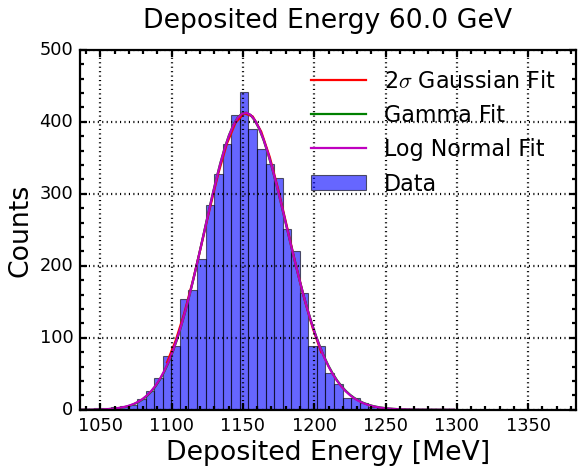

In [4]:
#This cell is left here for debug
(peak_gauss,peak_gauss_error,res_gauss,res_gauss_error,
 peak_gamma,peak_gamma_error,res_gamma,res_gamma_error,
 peak_log_normal,peak_log_normal_error,res_log_normal,res_log_normal_error) = fit_all(9,"E")




Initial Gamma Fit Parameters: [5000.0, 6.883944747674707, 0.50399488465826, 1.3246928239437832]
Gamma Fit Parameters: [2.73657200e+03 1.13139161e+01 1.12558423e+00 7.53190095e-01]
Gamma Fit Peak: 8.893923716937119 ± 0.03821866616643161, Resolution: 0.28485095372367086 ± 0.0040905000576497786
Initial Gaussian Fit Parameters: [4.56000000e+02 2.84850954e-01 8.89392372e+00]
Gaussian Fit Peak: 9.23386194945785 ± 0.0763040348895462, Resolution: 0.2583789658475631 ± 0.008889568871324263
Initial Log Normal Fit Parameters: [456.           0.71940053   3.87079725   7.4290548 ]
Log Normal Fit Parameters: [2.75218019e+03 2.67371363e-01 3.87079725e-03 9.43463870e+00]
Log Normal Fit Peak: 8.787594579764665 ± 0.04218916882740027, Resolution: 0.30290144117290224 ± 0.00687790152782226


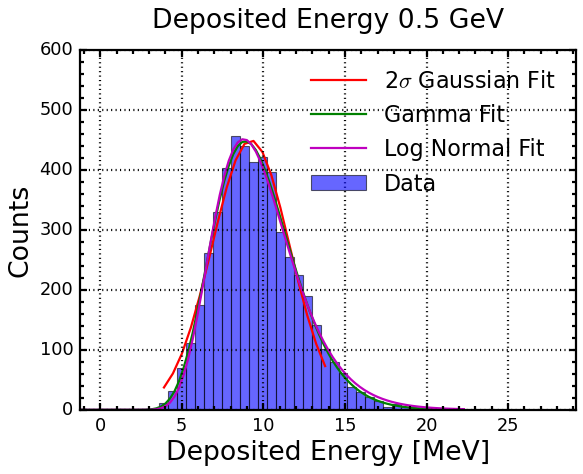

Initial Gamma Fit Parameters: [4999.0, 20.66821935927526, 13.797553260050055, 0.2621010860760826]
Gamma Fit Parameters: [3.66121765e+03 1.14851002e+01 6.89877663e+00 1.08081531e+00]
Gamma Fit Peak: 18.2312334615986 ± 0.07262932501252338, Resolution: 0.20091059079182885 ± 0.0035878640420019575
Initial Gaussian Fit Parameters: [4.34000000e+02 2.00910591e-01 1.82312335e+01]
Gaussian Fit Peak: 18.727601214261746 ± 0.11242720591066528, Resolution: 0.186621811560567 ± 0.006475970842799337
Initial Log Normal Fit Parameters: [434.           0.51464985   6.03773992  16.83136671]
Log Normal Fit Parameters: [3.67088427e+03 1.89721955e-01 6.03774038e-03 1.89345122e+01]
Log Normal Fit Peak: 18.27113306963731 ± 0.07169128090254447, Resolution: 0.20199568236946033 ± 0.0038117503770860135


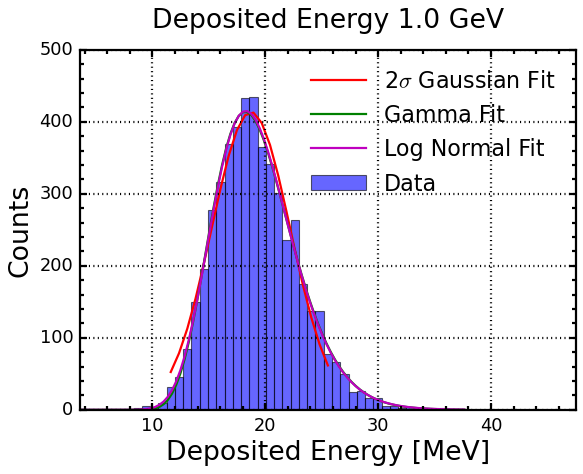

Initial Gamma Fit Parameters: [5000.0, 25.757045229799765, 30.012915255307362, 0.3258261813262493]
Gamma Fit Parameters: [5.08923731e+03 2.09958313e+01 1.50064576e+01 1.12479421e+00]
Gamma Fit Peak: 37.4976528715257 ± 0.100582595029058, Resolution: 0.13744708192929864 ± 0.0021045329294159688
Initial Gaussian Fit Parameters: [4.08000000e+02 1.37447082e-01 3.74976529e+01]
Gaussian Fit Peak: 38.01321560079568 ± 0.11135162212658513, Resolution: 0.13172312033228165 ± 0.0031733388804541193
Initial Log Normal Fit Parameters: [4.08000000e+02 3.69811822e-01 7.44875616e+00 3.58668469e+01]
Log Normal Fit Parameters: [5.09635534e+03 1.33338524e-01 7.44875617e-03 3.82212777e+01]
Log Normal Fit Peak: 37.55518941574967 ± 0.09603075763222982, Resolution: 0.13752599427021223 ± 0.002054610297539328


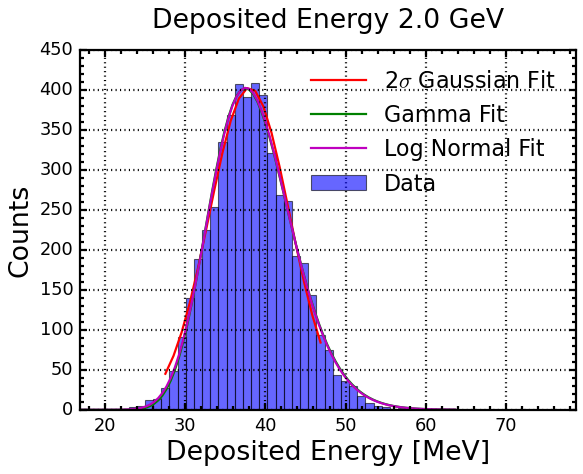

Initial Gamma Fit Parameters: [4998.0, 15.996612416141842, 60.68221922468712, 2.2193473175975242]
Gamma Fit Parameters: [8.30659063e+03 5.53294627e+01 3.48803389e+01 1.10967369e+00]
Gamma Fit Peak: 95.16831404948212 ± 0.14806702958048645, Resolution: 0.08673235492497207 ± 0.0010805910813881197
Initial Gaussian Fit Parameters: [4.10000000e+02 8.67323549e-02 9.51683140e+01]
Gaussian Fit Peak: 95.69363605592955 ± 0.17456866374923477, Resolution: 0.08545162793417926 ± 0.001976722097658462
Initial Log Normal Fit Parameters: [4.10000000e+02 2.44082223e-01 6.00320928e+00 9.33613680e+01]
Log Normal Fit Parameters: [8.31049992e+03 8.65171355e-02 8.74738093e-01 9.50265130e+01]
Log Normal Fit Peak: 95.19261265757326 ± 0.1487315484753281, Resolution: 0.08685249036751376 ± 0.0011394356262890938


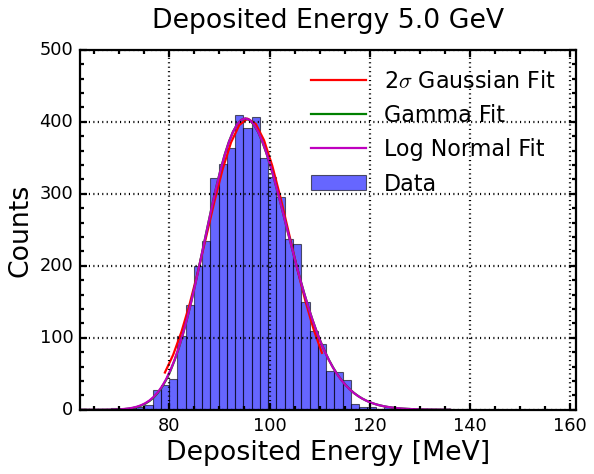

Initial Gamma Fit Parameters: [4998.0, 148.81688684024294, 184.7418058120694, 0.05145069405685376]
Gamma Fit Parameters: [1.16265183e+04 7.90868937e+01 9.23709029e+01 1.27009087e+00]
Gamma Fit Peak: 191.54835401422548 ± 0.17549760936834488, Resolution: 0.05896694530261393 ± 0.0006164700495472642
Initial Gaussian Fit Parameters: [4.19000000e+02 5.89669453e-02 1.91548354e+02]
Gaussian Fit Peak: 192.14834942112162 ± 0.16321314636320342, Resolution: 0.058193893248531664 ± 0.0009061783431932655
Initial Log Normal Fit Parameters: [4.19000000e+02 1.74118966e-01 8.50212282e+00 1.89504019e+02]
Log Normal Fit Parameters: [1.16310408e+04 5.85266539e-02 8.50212339e-03 1.92337125e+02]
Log Normal Fit Peak: 191.6879286217224 ± 0.16523404960162102, Resolution: 0.058875942399186115 ± 0.0005782643488957852


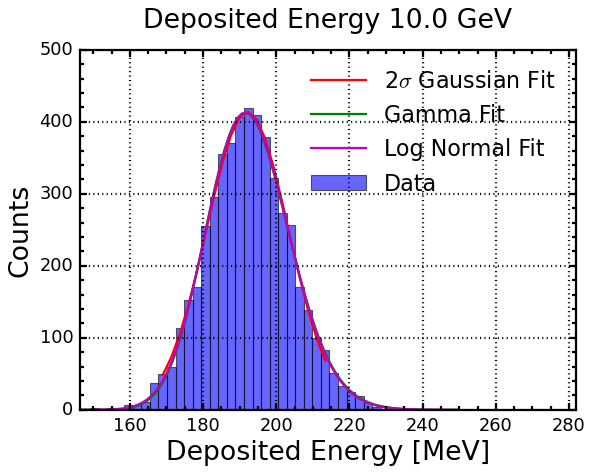

Initial Gamma Fit Parameters: [4996.0, 24.95855790151731, 288.9745780495151, 3.8237171103840524]
Gamma Fit Parameters: [1.67432135e+04 7.03741675e+01 2.50403656e+02 1.91185856e+00]
Gamma Fit Peak: 383.03725179560945 ± 0.23731746661408482, Resolution: 0.04187177592178784 ± 0.0004166419141595825
Initial Gaussian Fit Parameters: [4.23000000e+02 4.18717759e-02 3.83037252e+02]
Gaussian Fit Peak: 383.9277339238615 ± 0.22123538248915403, Resolution: 0.04114532198536281 ± 0.0006238403983886585
Initial Log Normal Fit Parameters: [4.23000000e+02 1.26453343e-01 1.29343275e+01 3.81347860e+02]
Log Normal Fit Parameters: [1.67255537e+04 4.14429400e-02 1.29343277e-02 3.84137040e+02]
Log Normal Fit Peak: 383.49077808460265 ± 0.21319993440941698, Resolution: 0.041566291163649585 ± 0.00035843076366273013


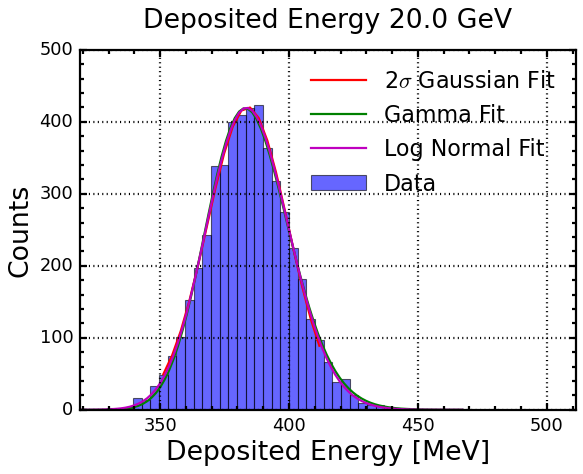

Initial Gamma Fit Parameters: [4995.0, 25.663275703669857, 403.6349304457515, 6.740726496366278]
Gamma Fit Parameters: [2.27133211e+04 3.62357561e+01 4.56204211e+02 3.37036325e+00]
Gamma Fit Peak: 574.961508681315 ± 0.5181174124331116, Resolution: 0.035286339076810336 ± 0.0006319934622426319
Initial Gaussian Fit Parameters: [4.52000000e+02 3.52863391e-02 5.74961509e+02]
Gaussian Fit Peak: 576.6439810285552 ± 0.4433135468155099, Resolution: 0.0345678381889476 ± 0.0008252581141971764
Initial Log Normal Fit Parameters: [4.52000000e+02 1.15167786e-01 4.61808713e+00 5.72812644e+02]
Log Normal Fit Parameters: [2.26512135e+04 3.45542632e-02 4.61808735e-03 5.76800926e+02]
Log Normal Fit Peak: 576.1172563937579 ± 0.41666912778610277, Resolution: 0.03462626311493748 ± 0.00047299269179371946


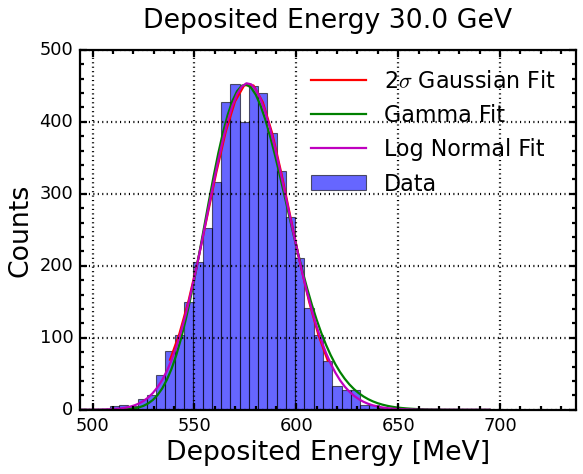

Initial Gamma Fit Parameters: [4994.0, 29.322634041960594, 602.3333944608412, 5.666413472082468]
Gamma Fit Parameters: [2.41519949e+04 6.77807459e+01 5.77770513e+02 2.83320674e+00]
Gamma Fit Peak: 766.9741716928814 ± 0.40693724539913373, Resolution: 0.03041240031637933 ± 0.00035605776814590686
Initial Gaussian Fit Parameters: [4.29000000e+02 3.04124003e-02 7.66974172e+02]
Gaussian Fit Peak: 768.3954527435084 ± 0.36860864981917413, Resolution: 0.03024112054900719 ± 0.0005123366360357328
Initial Log Normal Fit Parameters: [4.29000000e+02 9.06416132e-02 1.50790224e+01 7.65337129e+02]
Log Normal Fit Parameters: [2.41275787e+04 3.01069963e-02 1.50790488e-02 7.68553548e+02]
Log Normal Fit Peak: 767.87230220674 ± 0.3546443562811139, Resolution: 0.030154199875003788 ± 0.00029481387390127843


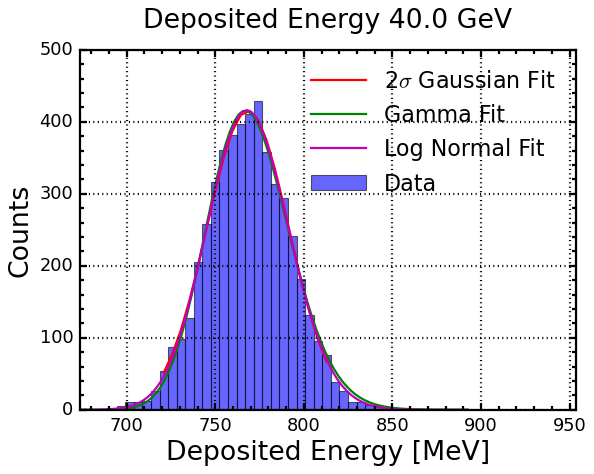

Initial Gamma Fit Parameters: [4999.0, 55.40873823692631, 840.0998757479224, 2.181194147330757]
Gamma Fit Parameters: [2.82025571e+04 4.43142620e+02 4.20049938e+02 1.22197319e+00]
Gamma Fit Peak: 960.336366201275 ± 0.4861483984888391, Resolution: 0.026786135637752194 ± 0.00032392819314535287
Initial Gaussian Fit Parameters: [4.61000000e+02 2.67861356e-02 9.60336366e+02]
Gaussian Fit Peak: 960.9056353898402 ± 0.5269753932672493, Resolution: 0.026620742892024776 ± 0.0005963242314210644
Initial Log Normal Fit Parameters: [4.61000000e+02 8.50034292e-02 1.25401683e+01 9.57491617e+02]
Log Normal Fit Parameters: [2.82047294e+04 2.67497237e-02 1.25401703e-02 9.61105382e+02]
Log Normal Fit Peak: 960.4304511779015 ± 0.48344971189902247, Resolution: 0.026782891524922248 ± 0.0003212801863194643


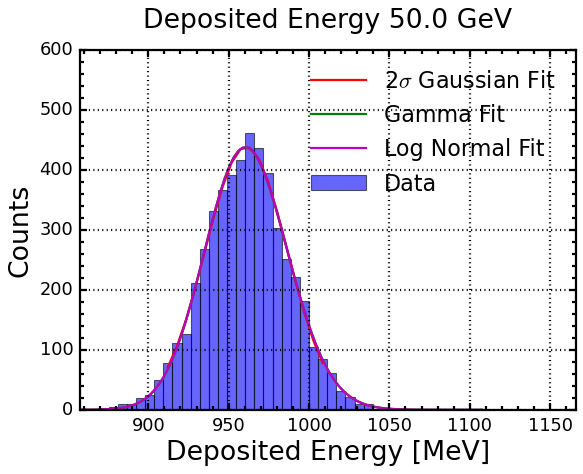

Initial Gamma Fit Parameters: [4997.0, 73.56197468828549, 1050.034637426254, 1.388985358216587]
Gamma Fit Parameters: [2.99476385e+04 4.69687601e+02 5.25017319e+02 1.33702329e+00]
Gamma Fit Peak: 1151.6635579815252 ± 0.5427671778029518, Resolution: 0.025160420570201316 ± 0.0003012645035556242
Initial Gaussian Fit Parameters: [4.41000000e+02 2.51604206e-02 1.15166356e+03]
Gaussian Fit Peak: 1152.337932221399 ± 0.5784707954195638, Resolution: 0.025166796775025504 ± 0.0005494786994918499
Initial Log Normal Fit Parameters: [4.41000000e+02 7.51375249e-02 8.32728280e+00 1.14896324e+03]
Log Normal Fit Parameters: [2.99513185e+04 2.51306928e-02 8.32728282e-03 1.15250524e+03]
Log Normal Fit Peak: 1151.7859292737414 ± 0.5378291291498912, Resolution: 0.025158301311854012 ± 0.00029920628608882835


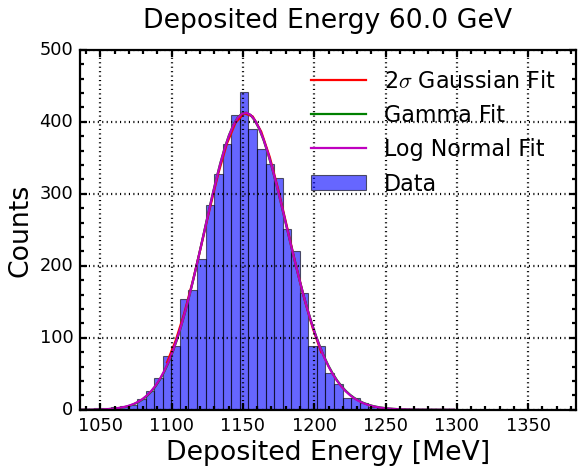

In [5]:
#Fit Sum of E and Save as CSV
results = []
for i_E in range(len(ParticleEnergy)):
    (peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(i_E, "E")    
    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, "SumE_Fit.csv")
df.to_csv(outputfile_name, index=False)



Initial Gamma Fit Parameters: [5000.0, 20.850536689733268, 7.06212075937569, 0.5762]
Gamma Fit Parameters: [5.00606663e+03 1.58178577e+01 3.53106038e+00 9.97549094e-01]
Gamma Fit Peak: 18.31260089152735 ± 0.06813046528206994, Resolution: 0.2166496940321816 ± 0.0031955936434821517
Initial Gaussian Fit Parameters: [5.32000000e+02 2.16649694e-01 1.83126009e+01]
Gaussian Fit Peak: 18.797373144508477 ± 0.08317777984891128, Resolution: 0.20470053546154743 ± 0.004788713713258954
Initial Log Normal Fit Parameters: [532.           0.72371645   9.80460798  14.68106743]
Log Normal Fit Parameters: [5.01993656e+03 2.07373572e-01 9.80460798e-03 1.90047039e+01]
Log Normal Fit Peak: 18.214557811860985 ± 0.08095839725141284, Resolution: 0.22347031989087984 ± 0.004710556959557397


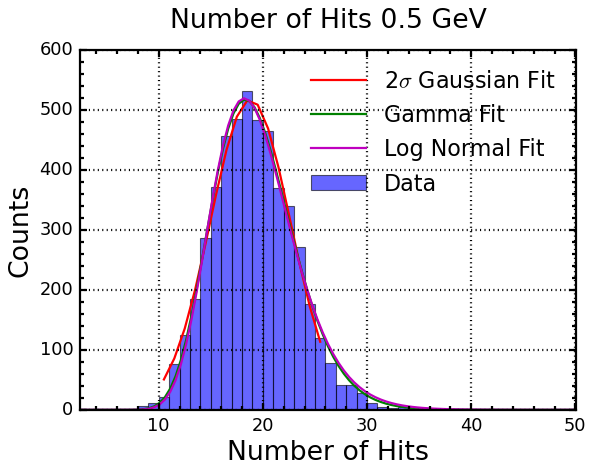

Initial Gamma Fit Parameters: [5000.0, 27.192102774645985, 11.295007560498398, 1.6148000000000025]
Gamma Fit Parameters: [1.00136987e+04 2.43076723e+01 5.64750378e+00 1.11959590e+00]
Gamma Fit Peak: 31.742678198955936 ± 0.09022555408317856, Resolution: 0.1738959313875068 ± 0.002235556594105077
Initial Gaussian Fit Parameters: [7.24000000e+02 1.73895931e-01 3.17426782e+01]
Gaussian Fit Peak: 32.24188999234966 ± 0.14309814397160306, Resolution: 0.16624086827070172 ± 0.004803955243950532
Initial Log Normal Fit Parameters: [724.           0.86751408  20.4524337   22.386897  ]
Log Normal Fit Parameters: [1.00307514e+04 1.69037547e-01 2.04524337e-02 3.25148342e+01]
Log Normal Fit Peak: 31.619365720186178 ± 0.10255587107577965, Resolution: 0.17759306643523357 ± 0.003115845907969486


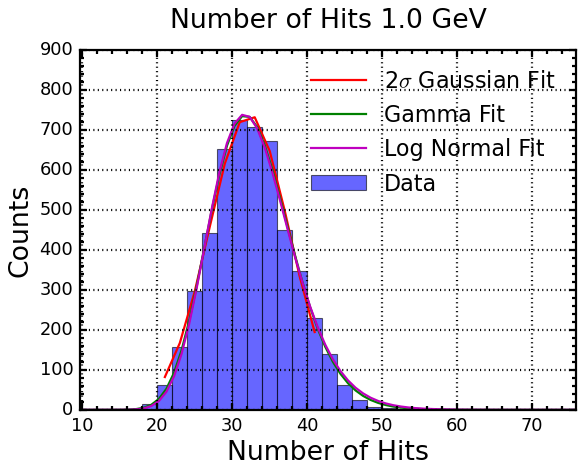

Initial Gamma Fit Parameters: [5000.0, 33.45049831087261, 30.116957895222768, 0.7668000000000035]
Gamma Fit Parameters: [9.94468409e+03 3.35612775e+01 1.50584789e+01 1.22021837e+00]
Gamma Fit Peak: 54.79034800842592 ± 0.11155024537148099, Resolution: 0.1290187242402291 ± 0.0015048364951268547
Initial Gaussian Fit Parameters: [5.98000000e+02 1.29018724e-01 5.47903480e+01]
Gaussian Fit Peak: 55.31853630101186 ± 0.1394993138549743, Resolution: 0.12412690252366937 ± 0.002727770218971895
Initial Log Normal Fit Parameters: [5.98000000e+02 4.93602993e-01 1.63049053e+01 4.93706814e+01]
Log Normal Fit Parameters: [9.95648939e+03 1.26516186e-01 1.63049053e-02 5.56074576e+01]
Log Normal Fit Peak: 54.74077590903177 ± 0.11424178685758651, Resolution: 0.1300720841999524 ± 0.0016863908001032294


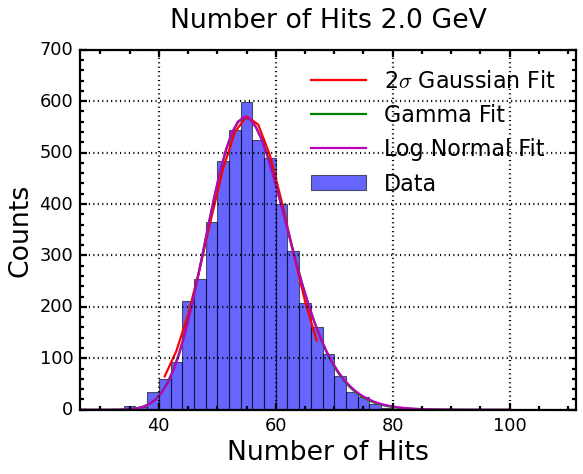

Initial Gamma Fit Parameters: [5000.0, 43.338138029182225, 67.65232335836592, 1.056600000000003]
Gamma Fit Parameters: [1.49979335e+04 5.95676293e+01 3.38261617e+01 1.34508002e+00]
Gamma Fit Peak: 112.60430982292873 ± 0.23477008393794105, Resolution: 0.09219306794810639 ± 0.0014448531311845071
Initial Gaussian Fit Parameters: [5.98000000e+02 9.21930679e-02 1.12604310e+02]
Gaussian Fit Peak: 113.25658540915036 ± 0.2660382560438159, Resolution: 0.09089672216812705 ± 0.002534222984246203
Initial Log Normal Fit Parameters: [5.98000000e+02 3.78695134e-01 2.30137189e+01 1.05593734e+02]
Log Normal Fit Parameters: [1.50068621e+04 9.12063128e-02 2.30137189e-02 1.13489576e+02]
Log Normal Fit Peak: 112.57243218310376 ± 0.2377341476938596, Resolution: 0.09252497746115644 ± 0.0015125114583307668


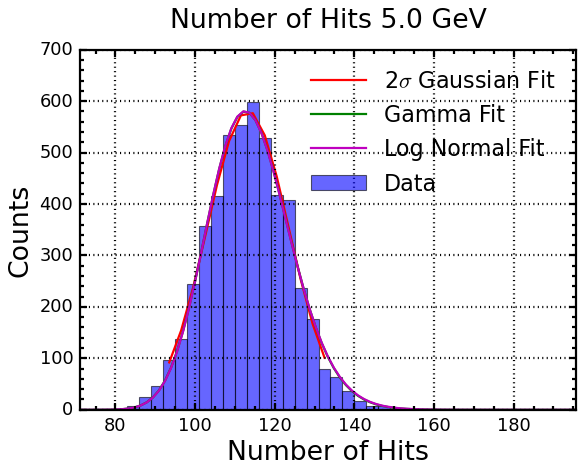

Initial Gamma Fit Parameters: [5000.0, 31.675487541043847, 84.31492342222425, 3.3567999999999927]
Gamma Fit Parameters: [1.99662449e+04 6.44985358e+01 8.27866924e+01 1.67840000e+00]
Gamma Fit Peak: 189.36263491969237 ± 0.1639144032107031, Resolution: 0.0711829710663586 ± 0.0005915179545259339
Initial Gaussian Fit Parameters: [5.90000000e+02 7.11829711e-02 1.89362635e+02]
Gaussian Fit Peak: 190.16347380970842 ± 0.2522681635713244, Resolution: 0.07001890805830763 ± 0.0014586725888702415
Initial Log Normal Fit Parameters: [5.90000000e+02 2.97695053e-01 2.70874368e+01 1.82380004e+02]
Log Normal Fit Parameters: [1.99599994e+04 7.04158784e-02 2.70874385e-02 1.90409445e+02]
Log Normal Fit Peak: 189.49474344656815 ± 0.15821064926025538, Resolution: 0.07101943214202855 ± 0.0005631445750130138


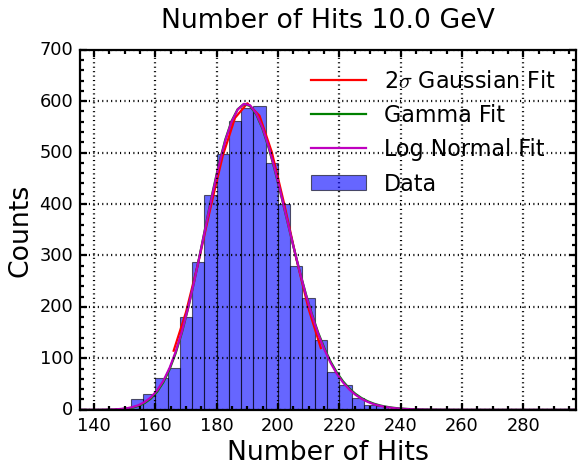

Initial Gamma Fit Parameters: [5000.0, 122.56022357747302, 268.3890001828387, 0.35700000000002774]
Gamma Fit Parameters: [2.49359762e+04 1.02145293e+02 1.34194500e+02 1.74595998e+00]
Gamma Fit Peak: 310.7901336017559 ± 0.33662701323384414, Resolution: 0.056777496635100115 ± 0.0007203690056281989
Initial Gaussian Fit Parameters: [6.13000000e+02 5.67774966e-02 3.10790134e+02]
Gaussian Fit Peak: 311.6360693885971 ± 0.42748172848547283, Resolution: 0.056482179552953066 ± 0.001494076419164446
Initial Log Normal Fit Parameters: [6.13000000e+02 2.31465938e-01 2.44607672e+01 3.03892243e+02]
Log Normal Fit Parameters: [2.49422966e+04 5.64367379e-02 2.44607672e-02 3.11885576e+02]
Log Normal Fit Peak: 310.9182283434473 ± 0.3305777270501686, Resolution: 0.056747738069489725 ± 0.0007091134143925399


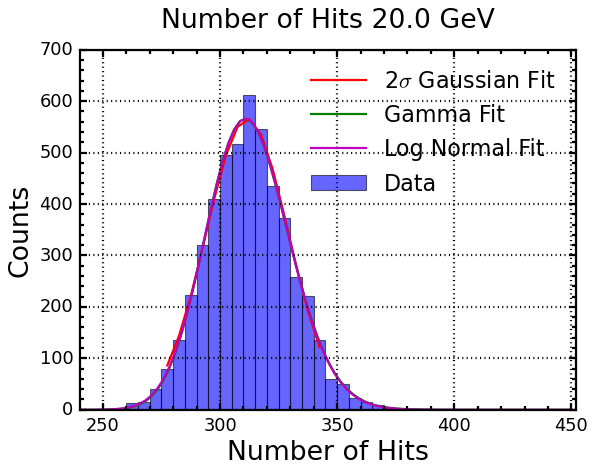

Initial Gamma Fit Parameters: [4999.0, 36.54766455899649, 269.5701633347792, 3.939787957591534]
Gamma Fit Parameters: [2.49525562e+04 1.10394815e+02 1.96756835e+02 1.96989398e+00]
Gamma Fit Peak: 412.2530230452386 ± 0.3520004431359401, Resolution: 0.050205736501963756 ± 0.0005649922757251912
Initial Gaussian Fit Parameters: [5.01000000e+02 5.02057365e-02 4.12253023e+02]
Gaussian Fit Peak: 413.17090369142113 ± 0.3842325012201434, Resolution: 0.049804241946341456 ± 0.0009961895802331597
Initial Log Normal Fit Parameters: [5.01000000e+02 1.74083917e-01 2.23184402e+01 4.07340936e+02]
Log Normal Fit Parameters: [2.49339308e+04 4.98354474e-02 2.23184402e-02 4.13469567e+02]
Log Normal Fit Peak: 412.46627801019906 ± 0.339622218822786, Resolution: 0.0500498142440451 ± 0.0005386326558926278


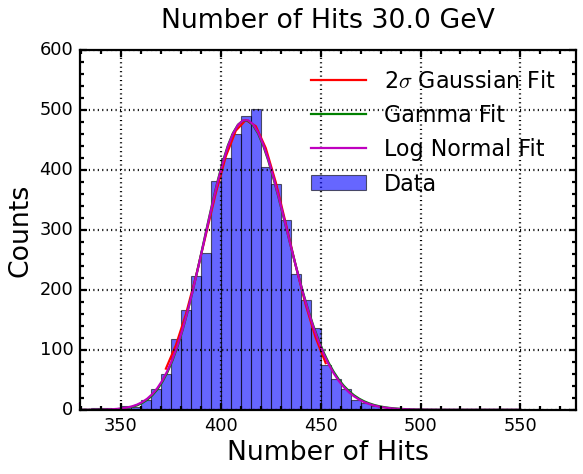

Initial Gamma Fit Parameters: [4999.0, 36.81955165871227, 298.6776253631052, 5.536707341468286]
Gamma Fit Parameters: [2.99189947e+04 6.49711688e+01 3.23527660e+02 2.76835367e+00]
Gamma Fit Peak: 500.62248049826684 ± 0.40732087055949107, Resolution: 0.04457296914631842 ± 0.0005499710390060469
Initial Gaussian Fit Parameters: [5.77000000e+02 4.45729691e-02 5.00622480e+02]
Gaussian Fit Peak: 501.9026232814455 ± 0.47945449682194013, Resolution: 0.044011556758692796 ± 0.0010300867929231774
Initial Log Normal Fit Parameters: [5.77000000e+02 1.71138912e-01 1.60631869e+01 4.95231051e+02]
Log Normal Fit Parameters: [2.98809187e+04 4.40650037e-02 1.60631869e-02 5.02225504e+02]
Log Normal Fit Peak: 501.2673296530444 ± 0.3796073609610793, Resolution: 0.04421357862137922 ± 0.0005008693322042323


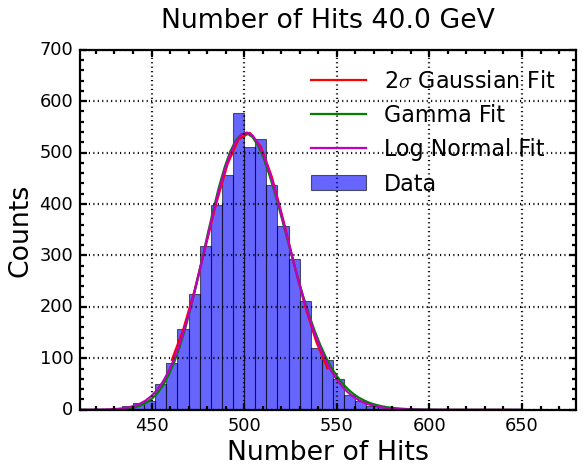

Initial Gamma Fit Parameters: [4998.0, 79.47378932953053, 454.0820191061187, 1.6330532212884918]
Gamma Fit Parameters: [3.47825392e+04 2.14718649e+02 2.27041010e+02 1.66651305e+00]
Gamma Fit Peak: 583.2059272407654 ± 0.3523099582579124, Resolution: 0.04187180400819854 ± 0.00039193292354915496
Initial Gaussian Fit Parameters: [5.77000000e+02 4.18718040e-02 5.83205927e+02]
Gaussian Fit Peak: 583.970433422215 ± 0.4005900627542723, Resolution: 0.041390775313736805 ± 0.0007404385594228492
Initial Log Normal Fit Parameters: [5.77000000e+02 1.72649692e-01 2.71638212e+01 5.75229544e+02]
Log Normal Fit Parameters: [3.47889556e+04 4.17547379e-02 2.81102261e-02 5.84264554e+02]
Log Normal Fit Peak: 583.2749107843296 ± 0.34766454007396214, Resolution: 0.0418803124632039 ± 0.00038835131049352634


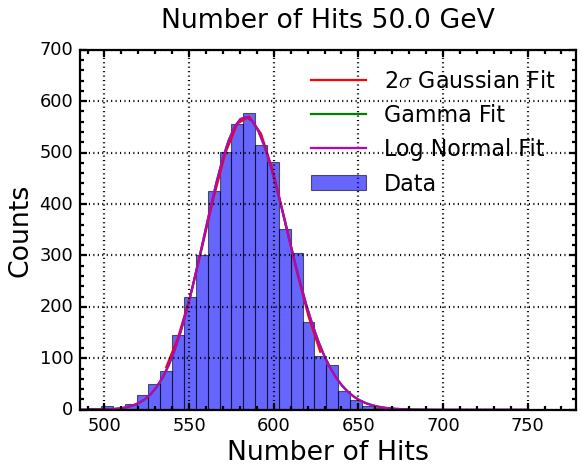

Initial Gamma Fit Parameters: [4997.0, 106.73367611643518, 587.3356535098972, 0.6651991194717084]
Gamma Fit Parameters: [2.96552821e+04 2.06002625e+02 2.93667827e+02 1.77606006e+00]
Gamma Fit Peak: 657.7648014734657 ± 0.5659242015073837, Resolution: 0.03875461222270627 ± 0.0005579450968998395
Initial Gaussian Fit Parameters: [5.14000000e+02 3.87546122e-02 6.57764801e+02]
Gaussian Fit Peak: 658.6557711146118 ± 0.5811374658095977, Resolution: 0.0382539711649185 ± 0.0009533455989648237
Initial Log Normal Fit Parameters: [5.14000000e+02 1.31657555e-01 1.75616669e+01 6.52653762e+02]
Log Normal Fit Parameters: [2.96614552e+04 3.86419300e-02 1.75616678e-02 6.58876677e+02]
Log Normal Fit Peak: 657.9111387125843 ± 0.5539532640164001, Resolution: 0.038742004831898595 ± 0.0005465936385221744


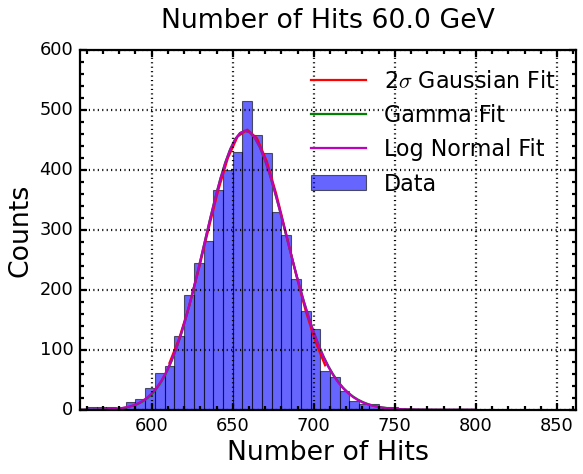

In [6]:
#Fit Number of hits and Save as CSV
results = []
for i_E in range(len(ParticleEnergy)):
    (peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(i_E, "N")
    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, "NHits_Fit.csv")
df.to_csv(outputfile_name, index=False)

